In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from matplotlib import pyplot as plt
import numpy as np

In [5]:
np.set_printoptions(suppress=True)

In [6]:
from IPython.display import Image

In [7]:
import GPy, pickle

In [8]:
import pandas as pd

In [9]:
import time

In [10]:
from incremental_run import Data, loadData, plot_kernels_sample_1d, plot_kernels_sample, compute_several_stats

new attribute for sparse GP!!


In [11]:
from incremental_run import Partition, RunFullGP, RunSparseGP, RunPoE, RunGRBCM, RunINC, statsDF, ResultRun

In [12]:
from mix import r,r1,r2,r3

In [13]:
seed=10

In [14]:
data = pd.read_csv('UCIeval/DATelecdemand1.csv', index_col=0)   #(17520, 4) #local

In [15]:
data = np.array(data)

In [16]:
data.shape

(17520, 4)

In [17]:
data = data[:48*364,:] ## cut last day!!!!!

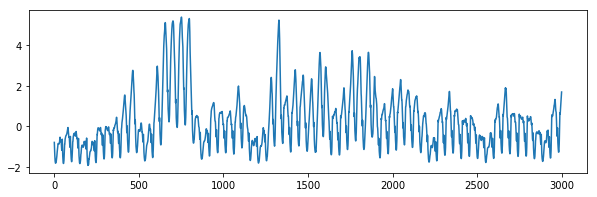

In [18]:
plt.figure(figsize=(10,3))
plt.plot( data[:,-1][:3000] )

#plt.plot( data[:,2][:3000] )

In [19]:
#data = data[:1000,:]

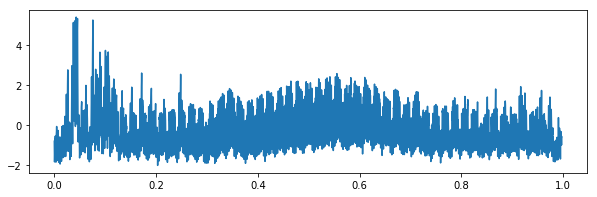

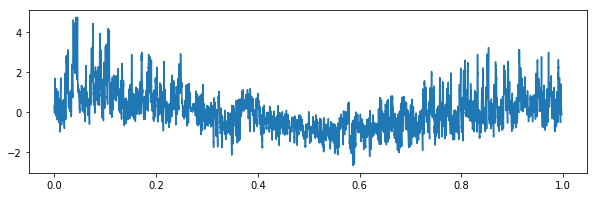

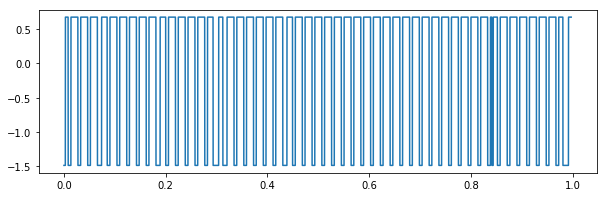

In [20]:
plt.figure(figsize=(10,3))
plt.plot( data[:,0] , data[:,-1] )

plt.figure(figsize=(10,3))
plt.plot(  data[:,0] , data[:,1] )

plt.figure(figsize=(10,3))
plt.plot(  data[:,0] , data[:,2] )

In [21]:
weekScale = 7/365 ## 1 week
weekScale

0.019178082191780823

In [22]:
# take only D=1
D=100#1

In [23]:
# create 3 weeks, 1 week indices
ind31 = np.tile( np.repeat( np.array([0,0,0,1]), 336) , 13 ) 
#ind31 = np.tile( np.repeat( np.array([0,0,1,1]), 336) , 13 ) 
train_ind = np.where(ind31==0)[0]
test_ind = np.where(ind31==1)[0]

In [24]:
len(ind31)

17472

In [25]:
sum(ind31)

4368

In [26]:
sum(1-ind31)

13104

In [27]:
len(train_ind)

13104

In [28]:
len(test_ind)

4368

In [29]:
ff = 6#2#6  # sub sample factor for training
e1 = 4  # sub sample factor for testing IN
e2 = 6 # sub sample factor for testing OUT

In [30]:
len(train_ind)/ff

2184.0

In [31]:
len(test_ind)/ff

728.0

In [32]:
g = np.zeros(ff, dtype=int)
g[-1] = 1
gg = np.tile( g, int(len(train_ind)/ff) )

In [33]:
indTrain = train_ind[ np.where(  gg ==1 )[0] ]

In [34]:
len(indTrain)

2184

In [35]:
indTrain

array([    5,    11,    17, ..., 17123, 17129, 17135])

In [36]:
2184/13/3/7

8.0

In [37]:
indTest_IN = train_ind[ np.where(   gg==0 )[0] ]

In [38]:
len(indTest_IN)

10920

In [39]:
indTest_OUT = test_ind

In [40]:
len(indTest_OUT)

4368

In [41]:
indTest = np.hstack([indTest_IN, indTest_OUT])
#indTest = test_ind

In [42]:
len(indTest)

15288

In [43]:
Ntest = len(indTest)
Ntrain = len(indTrain)
Ntrain, Ntest

(2184, 15288)

In [44]:
#np.random.seed(seed)

DD = Data(Ntrain=Ntrain, Ntest=Ntest)
#permN = np.random.permutation(Ntot)

if D==1:
    DD.X_train = data[indTrain,0:1]
    DD.X_test = data[indTest,0:1]
else:
    DD.X_train = data[indTrain,:-1]
    DD.X_test = data[indTest,:-1]

DD.y_train = data[indTrain,-1]
DD.y_test = data[indTest,-1]
DD.f_test = data[indTest,-1]

DD.Xt_IN = np.hstack([ np.ones(len(indTest_IN), dtype=bool), np.zeros(len(indTest_OUT), dtype=bool) ])
#DD.Xt_IN = None
DD.D = DD.X_train.shape[1]

In [45]:
DD.Xt_IN

array([ True,  True,  True, ..., False, False, False])

In [46]:
DD.plot_data()

not supported for D =  3


(0.0, 0.15342465753424658)

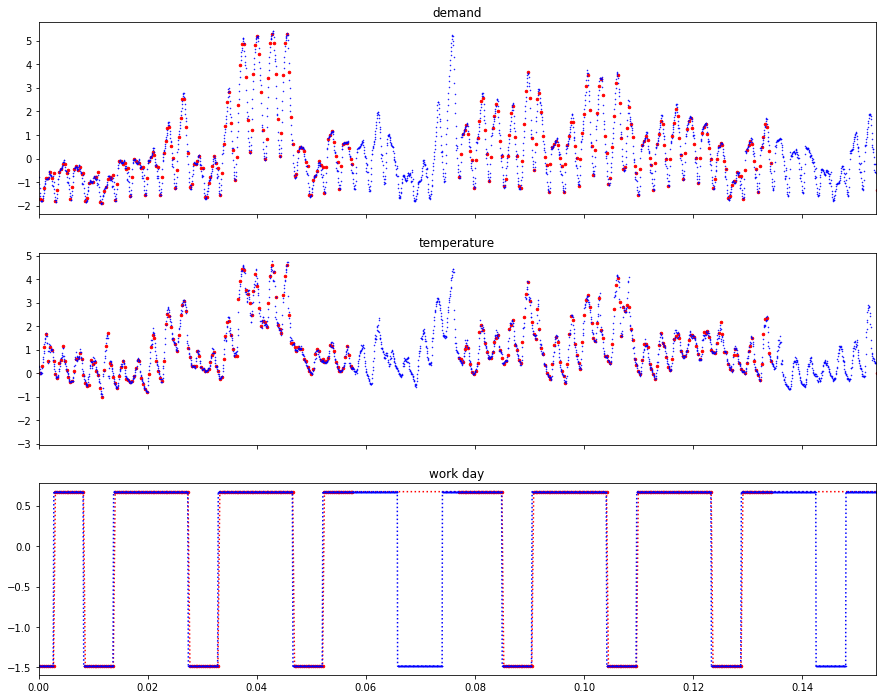

In [47]:
#plt.figure(figsize=(16,3))

f, axs = plt.subplots(3,1, sharex=True, sharey=False, figsize=(15,4*3) )

ind_xt = np.argsort(DD.X_test[:,0])
xt = DD.X_test[ind_xt,0]



ax = axs[0]
ax.plot( DD.X_train[:,0] , DD.y_train, 'r.', markersize=5, label='train')
ax.plot( xt, DD.y_test[ind_xt], 'b.', markersize=1, label='test')

ax.set_title('demand')


ax = axs[1]
ax.plot( DD.X_train[:,0] , DD.X_train[:,1], 'r.', markersize=5, label='train')
ax.plot( xt , DD.X_test[ind_xt,1], 'b.', markersize=1, label='test')

ax.set_title('temperature')


ax = axs[2]
ax.plot( DD.X_train[:,0] , DD.X_train[:,2], 'r.:', markersize=5, label='train')
ax.plot( xt , DD.X_test[ind_xt,2], 'b.:', markersize=1, label='test')

ax.set_title('work day')


ax.set_xlim(weekScale*0,weekScale*8)




#plt.savefig(''+'stochConv2'+'.pdf', bbox_inches = 'tight', pad_inches = 0);

In [48]:
np.exp(-1.1)

0.33287108369807955

In [49]:
PRIOR = True

In [50]:
# according to Giorgio paper
priorVar = GPy.priors.LogGaussian(-1.5, 1) 
priorPER = GPy.priors.LogGaussian(0.2, 1) 
priorPER2 = GPy.priors.LogGaussian(-1.5, 1) #########new!
priorRBF = GPy.priors.LogGaussian(1.1, 1) 

priorSM1_rbf = GPy.priors.LogGaussian(-0.7, 1) 
priorSM1_cos = GPy.priors.LogGaussian(0.5, 1) 
priorSM2_rbf = GPy.priors.LogGaussian(1.1, 1) 
priorSM2_cos = GPy.priors.LogGaussian(1.6, 1) 


In [51]:
var = np.exp(priorVar.mu)
var

0.22313016014842982

In [52]:
#dims?
#ARD1,2?

In [53]:
#RBF = GPy.kern.RBF(input_dim=1, variance=var, lengthscale=np.exp(priorRBF.mu), ARD = True)
#if PRIOR:
#    RBF.lengthscale.set_prior(priorRBF)
#    RBF.variance.set_prior(priorVar)

In [54]:
RBF = GPy.kern.RBF(input_dim=3, variance=var, lengthscale=np.exp(priorRBF.mu), ARD = True)
if PRIOR:
    RBF.lengthscale.set_prior(priorRBF)
    RBF.variance.set_prior(priorVar)

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.variance


In [55]:
LIK = GPy.likelihoods.Gaussian(variance=var)
if PRIOR:
    LIK.variance.set_prior(priorVar)

reconstraining parameters Gaussian_noise.variance


In [56]:
PER1 = GPy.kern.StdPeriodic(input_dim=1, variance=var, lengthscale=np.exp(priorPER.mu), period=1/365 )
PER2 = GPy.kern.StdPeriodic(input_dim=1, variance=var, lengthscale=np.exp(priorPER2.mu), period=7/365 )
#PER1 = GPy.kern.StdPeriodic(input_dim=1, variance=var, lengthscale=0.5, period=1/365 )
#PER2 = GPy.kern.StdPeriodic(input_dim=1, variance=var, lengthscale=0.5, period=7/365 )
#print('init lengthscalse')

print('new prior for PER2!!!!')
if PRIOR:
    PER1.lengthscale.set_prior(priorPER)
    PER2.lengthscale.set_prior(priorPER2)
    PER1.variance.set_prior(priorVar)
    PER2.variance.set_prior(priorVar)

reconstraining parameters std_periodic.lengthscale
reconstraining parameters std_periodic.lengthscale
reconstraining parameters std_periodic.variance
reconstraining parameters std_periodic.variance


new prior for PER2!!!!


In [57]:
PER1.period.fix()
PER2.period.fix()

array([0])

In [58]:
LIN = GPy.kern.Linear(input_dim = 1, variances=var, ARD=True)
if PRIOR:
    LIN.variances.set_prior(priorVar)

reconstraining parameters linear.variances


In [59]:
SM1 = GPy.kern.RBF(input_dim=1, variance=var, lengthscale=np.exp(priorSM1_rbf.mu) ) \
    * GPy.kern.Cosine(input_dim=1, variance=var, lengthscale=np.exp(priorSM1_cos.mu))

In [60]:
SM2 = GPy.kern.RBF(input_dim=1, variance=var, lengthscale=np.exp(priorSM2_rbf.mu) ) \
    * GPy.kern.Cosine(input_dim=1, variance=var, lengthscale=np.exp(priorSM2_cos.mu))

In [61]:
if PRIOR:
    SM1.rbf.variance.set_prior(priorVar)
    SM1.rbf.lengthscale.set_prior(priorSM1_rbf)
    SM1.Cosine.variance.set_prior(priorVar)
    SM1.Cosine.lengthscale.set_prior(priorSM1_cos)

reconstraining parameters mul.rbf.variance
reconstraining parameters mul.rbf.lengthscale
reconstraining parameters mul.Cosine.variance
reconstraining parameters mul.Cosine.lengthscale


In [62]:
if PRIOR:
    SM2.rbf.variance.set_prior(priorVar)
    SM2.rbf.lengthscale.set_prior(priorSM2_rbf)
    SM2.Cosine.variance.set_prior(priorVar)
    SM2.Cosine.lengthscale.set_prior(priorSM2_cos)

reconstraining parameters mul.rbf.variance
reconstraining parameters mul.rbf.lengthscale
reconstraining parameters mul.Cosine.variance
reconstraining parameters mul.Cosine.lengthscale


In [63]:
#kern = PER1 + PER2 + LIN + RBF + SM1 + SM2
kern = PER1 + PER2 + RBF + SM1 
#kern = PER1 + PER2 + RBF + SM1 + SM2

#kern = PER1 + PER2 + RBF 

In [64]:
kern

sum.,value,constraints,priors
std_periodic.variance,0.22313016014842982,+ve,"lnN(-1.5, 1)"
std_periodic.period,0.0027397260273972603,+ve fixed,
std_periodic.lengthscale,1.2214027581601699,+ve,"lnN(0.2, 1)"
std_periodic_1.variance,0.22313016014842982,+ve,"lnN(-1.5, 1)"
std_periodic_1.period,0.019178082191780823,+ve fixed,
std_periodic_1.lengthscale,0.22313016014842982,+ve,"lnN(-1.5, 1)"
rbf.variance,0.22313016014842982,+ve,"lnN(-1.5, 1)"
rbf.lengthscale,"(3,)",+ve,"lnN(1.1, 1)"
mul.rbf.variance,0.22313016014842982,+ve,"lnN(-1.5, 1)"
mul.rbf.lengthscale,0.4965853037914095,+ve,"lnN(-0.7, 1)"


In [65]:
rFullGP = RunFullGP(DD, kern, likelihood=LIK, seed=seed).run(False)

RES = rFullGP.compute_stats(rFullGP.m, rFullGP.v)

RES

,time,lik,KLx1000,errFull,CRPS,errF,errAbs,negLogP,cov,KL_INx1000,...,errAbs_IN,negLogP_IN,cov_IN,KL_OUTx1000,errFull_OUT,CRPS_OUT,errF_OUT,errAbs_OUT,negLogP_OUT,cov_OUT
fullGP,15.952,-1486.83,0.0,0.0,0.251,0.448,0.353,1.238,0.959,0.0,...,0.344,1.198,0.964,0.0,0.0,0.267,0.473,0.377,1.339,0.947


(0.6136986301369863, 0.6904109589041096)

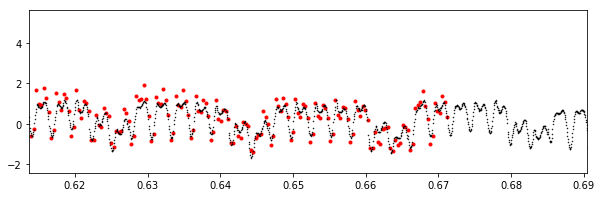

In [66]:
plt.figure(figsize=(10,3))
plt.plot( DD.X_train[:,0] , DD.y_train, 'r.' )

ind_xt = np.argsort(DD.X_test[:,0])
xt = DD.X_test[ind_xt,0]
plt.plot( xt, rFullGP.m[ind_xt], 'k.', markersize=1)


plt.xlim(weekScale*32,weekScale*36)

In [67]:
RES[['CRPS','CRPS_IN','CRPS_OUT']]

,CRPS,CRPS_IN,CRPS_OUT
fullGP,0.251,0.245,0.267


In [68]:
RES[['errF','errF_IN','errF_OUT']]

,errF,errF_IN,errF_OUT
fullGP,0.448,0.438,0.473


In [69]:
rFullGPo = RunFullGP(DD, kern, likelihood=LIK, seed=seed, priorN=priorVar).run(True, NRAND=0)

reconstraining parameters GP_regression.Gaussian_noise.variance


In [70]:
RESo = rFullGPo.compute_stats(rFullGPo.m, rFullGPo.v)

RESo

,time,lik,KLx1000,errFull,CRPS,errF,errAbs,negLogP,cov,KL_INx1000,...,errAbs_IN,negLogP_IN,cov_IN,KL_OUTx1000,errFull_OUT,CRPS_OUT,errF_OUT,errAbs_OUT,negLogP_OUT,cov_OUT
fullGP,613.555,-517.923,0.0,0.0,0.188,0.351,0.257,0.692,0.921,0.0,...,0.225,0.388,0.938,0.0,0.0,0.251,0.465,0.339,1.452,0.877


In [71]:
RESo[['CRPS','CRPS_IN','CRPS_OUT']]

,CRPS,CRPS_IN,CRPS_OUT
fullGP,0.188,0.162,0.251


In [72]:
RESo[['errF','errF_IN','errF_OUT']]

,errF,errF_IN,errF_OUT
fullGP,0.351,0.294,0.465


In [73]:
rFullGPo.obj.GPmod

GP_regression.,value,constraints,priors
sum.std_periodic.variance,0.4600280305350629,+ve,"lnN(-1.5, 1)"
sum.std_periodic.period,0.0027397260273972603,+ve fixed,
sum.std_periodic.lengthscale,0.3810787139864774,+ve,"lnN(0.2, 1)"
sum.std_periodic_1.variance,0.09953013729722603,+ve,"lnN(-1.5, 1)"
sum.std_periodic_1.period,0.019178082191780823,+ve fixed,
sum.std_periodic_1.lengthscale,0.0834733326595703,+ve,"lnN(-1.5, 1)"
sum.rbf.variance,1.0020358981550261,+ve,"lnN(-1.5, 1)"
sum.rbf.lengthscale,"(3,)",+ve,"lnN(1.1, 1)"
sum.mul.rbf.variance,0.1993662793157216,+ve,"lnN(-1.5, 1)"
sum.mul.rbf.lengthscale,0.003189867782962306,+ve,"lnN(-0.7, 1)"


In [74]:
rFullGPo.obj.GPmod.sum.rbf.lengthscale

index,GP_regression.sum.rbf.lengthscale,constraints,priors
[0],0.09156664,+ve,"lnN(1.1, 1)"
[1],1.52970704,+ve,"lnN(1.1, 1)"
[2],8.67598052,+ve,"lnN(1.1, 1)"


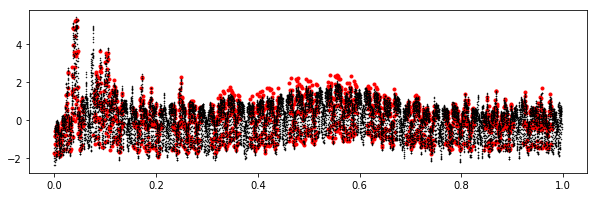

In [75]:
plt.figure(figsize=(10,3))
plt.plot( DD.X_train[:,0] , DD.y_train, 'r.' )

ind_xt = np.argsort(DD.X_test[:,0])
xt = DD.X_test[ind_xt,0]
plt.plot( xt, rFullGPo.m[ind_xt], 'k.', markersize=1)

(0.6136986301369863, 0.6904109589041096)

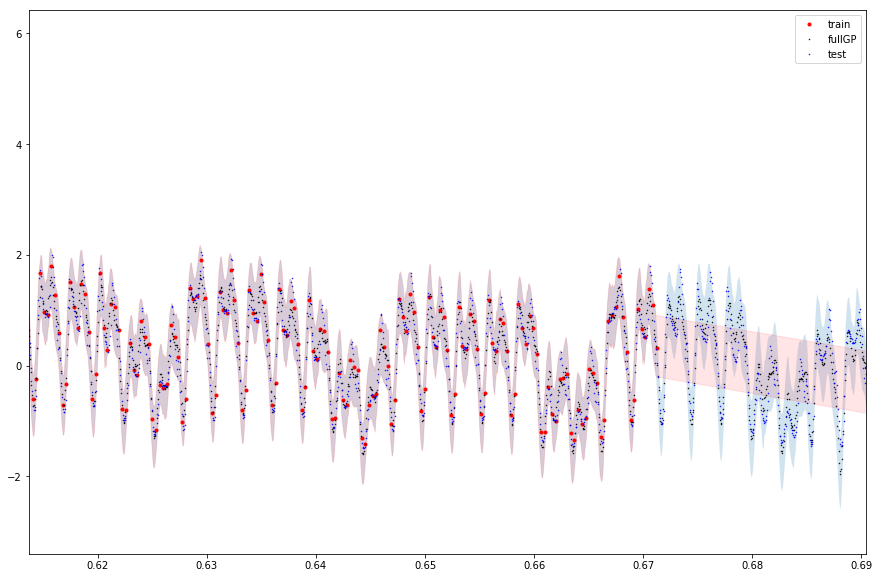

In [76]:
plt.figure(figsize=(15,10))
plt.plot( DD.X_train[:,0] , DD.y_train, 'r.', label='train')

ind_xt = np.argsort(DD.X_test[:,0])
xt = DD.X_test[ind_xt,0]

plt.plot( xt, rFullGPo.m[ind_xt], 'k.', markersize=1, label='fullGP')
plt.fill_between(xt, rFullGPo.CI[ind_xt,0], rFullGPo.CI[ind_xt,1], alpha= 0.2)


wIN = DD.Xt_IN[ind_xt]
plt.fill_between(xt[wIN], rFullGPo.CI[ind_xt,0][wIN], rFullGPo.CI[ind_xt,1][wIN], alpha= 0.1, color='red')

plt.plot( xt, DD.y_test[ind_xt], 'b.', markersize=1, label='test')
plt.legend()

plt.xlim(weekScale*32,weekScale*36)

In [77]:
#from CPoE_script_real1 import CPoE

In [78]:
from incremental_p import Independent
from CPoE import BlockGP
from incremental_run import Partition

In [79]:
# for sorted Partition
def CPoE(DD, kern, lik, K0, Ps, p=1, HYPERS='FIX', seed=0, TRACE=False, gamma=0.01, E=5, jit=1e-3, B_increase=False, J_MODE='FIX', REL=1e-10, priorN=None):
    #HYPERS: FIX, BATCH, STOCH
    #Ps should be list, also in the scalar case
    #if B_increase, then obviously only 1 P in Ps!!!!!!!!!!!!!

    
    if B_increase:
        Kinc = np.int( np.ceil( K0/(Ps[0]+1)  ) )
    else:
        Kinc = K0
        
    print('Kinc',Kinc)


    ST = time.time()
    if not HYPERS=='FIX':    
        
        PP = Partition(DD)
        PP.compute_partition(K=Kinc, KMEANS=False, sortDim=0)

        IND = Independent( DD, Kinc, kern, lik,  PP=PP, SPARSE=False, priorNoise=priorN)

        if HYPERS=='BATCH':
            IND.opt_batch(GTOL=5e-1, maxF=300, TRACE=TRACE)
        elif HYPERS=='STOCH':
            IND.run_epochs(E=E, gamma=gamma, U=1, TRACE=TRACE, PERM=True, PRINT=True, REL=REL)

        kern = IND.kern
        lik = IND.likelihood

    timeOPT= time.time()-ST

    BGP = BlockGP(kern, DD, lik)

    RESS = []
    for i,P in enumerate(Ps):

        BGP.run0(K0, P, sp=p, jit=jit, KMEANS=False, sortDim=0, seed=seed, TIMEOPT=timeOPT, J_MODE=J_MODE) 

        RES = BGP.run_opt(OPT=False)

        RESS.append(RES)


    return RESS

In [80]:

def PoE_temp(DD, kern, lik, K0,  HYPERS='FIX', seed=0, TRACE=False, gamma=0.01, E=5, REL=1e-10, namsePoE=None, priorN=None):
    #HYPERS: FIX, BATCH, STOCH

    B_STOP = int(np.ceil( DD.Ntrain / K0  ))
    argsPartPoE = {'KMEANS':False, 'sortDim':0}

    ST = time.time()
    if not HYPERS=='FIX':  

        PP = Partition(DD)
        PP.compute_partition(K=K0, KMEANS=False, sortDim=0)

        IND = Independent( DD, K0, kern, lik,  PP=PP, SPARSE=False, priorNoise=priorN)


        if HYPERS=='BATCH':
            IND.opt_batch(GTOL=5e-1, maxF=300, TRACE=TRACE)
        elif HYPERS=='STOCH':
            IND.run_epochs(E=E, gamma=gamma, U=1, TRACE=TRACE, PERM=True, PRINT=True, REL=REL)

        kern = IND.kern
        lik = IND.likelihood

    timeOPT= time.time()-ST
    
    

    rPoE = RunPoE(DD, K0, kern, lik,  seed=seed, **argsPartPoE, timeOpt=timeOPT)
    runGRBCM = RunGRBCM(DD, K0, kern, lik,  seed=seed, KMEANS=False, timeOpt=timeOPT)


    runsPoE = [rPoE.run(nam) for nam in namsePoE]
    rGRBCM = runGRBCM.run()
    runsPoE.append(rGRBCM)

    return runsPoE


In [108]:
K0 = 13 #6, 12, 13
K0

13

In [109]:
DD.Ntrain/K0

168.0

In [110]:
res = PoE_temp(DD, kern, LIK, K0,  HYPERS='BATCH', seed=seed,  namsePoE= np.array(['minVar','GPoE-scaled','BCM','RBCM']), priorN=priorVar)

reconstraining parameters GP_regression.Gaussian_noise.variance


K = 13
0.0001761913299560547


In [111]:
RES_P = compute_several_stats(res,  rFullGPo.m, rFullGPo.v)
RES_P

,time,lik,KLx1000,errFull,CRPS,errF,errAbs,negLogP,cov,KL_INx1000,...,errAbs_IN,negLogP_IN,cov_IN,KL_OUTx1000,errFull_OUT,CRPS_OUT,errF_OUT,errAbs_OUT,negLogP_OUT,cov_OUT
minVar,20.934,-410.362,503.037,0.241,0.168,0.316,0.230,0.530,0.896,406.451,...,0.202,0.184,0.913,744.503,0.325,0.224,0.420,0.301,1.395,0.851
GPoE-scaled,20.928,-410.362,328.009,0.287,0.219,0.408,0.299,1.001,0.927,336.045,...,0.284,0.900,0.937,307.917,0.306,0.247,0.460,0.338,1.256,0.902
BCM,20.843,-410.362,5210.492,0.321,0.274,0.435,0.326,10.333,0.453,4917.299,...,0.315,9.585,0.462,5943.474,0.325,0.301,0.472,0.355,12.202,0.428
RBCM,21.395,-410.362,4671.959,0.274,0.247,0.394,0.297,8.582,0.479,4269.270,...,0.280,7.645,0.492,5678.680,0.303,0.285,0.451,0.337,10.925,0.445
GRBCM,28.847,0.000,393.425,0.201,0.210,0.376,0.284,1.329,0.823,382.067,...,0.268,1.160,0.827,421.822,0.215,0.241,0.434,0.322,1.750,0.813


In [132]:
MMs = [20, 50, 100, 200, 300]

In [133]:
runsSparse = [ RunSparseGP(DD, kern, m, likelihood=LIK, priorN=priorVar, seed=seed+1).run(OPT_TH=True) for m in MMs]

reconstraining parameters sparse_gp.Gaussian_noise.variance
reconstraining parameters sparse_gp.Gaussian_noise.variance
reconstraining parameters sparse_gp.Gaussian_noise.variance
reconstraining parameters sparse_gp.Gaussian_noise.variance
reconstraining parameters sparse_gp.Gaussian_noise.variance


In [134]:
RES_SP = compute_several_stats(runsSparse,  rFullGPo.m, rFullGPo.v)
RES_SP

,time,lik,KLx1000,errFull,CRPS,errF,errAbs,negLogP,cov,KL_INx1000,...,errAbs_IN,negLogP_IN,cov_IN,KL_OUTx1000,errFull_OUT,CRPS_OUT,errF_OUT,errAbs_OUT,negLogP_OUT,cov_OUT
sparse20,35.324,-1158.535,336.090,0.288,0.242,0.428,0.345,1.147,0.935,348.189,...,0.340,1.128,0.938,305.842,0.302,0.250,0.439,0.358,1.197,0.928
sparse50,30.354,-806.516,159.338,0.178,0.215,0.391,0.297,0.965,0.911,175.304,...,0.279,0.804,0.929,119.423,0.164,0.252,0.459,0.344,1.369,0.864
sparse100,54.205,-683.918,120.859,0.148,0.202,0.370,0.277,0.882,0.908,110.522,...,0.259,0.678,0.928,146.701,0.168,0.239,0.440,0.322,1.392,0.858
sparse200,72.688,-608.247,114.941,0.146,0.189,0.347,0.262,0.699,0.922,65.611,...,0.249,0.583,0.931,238.265,0.216,0.216,0.400,0.297,0.989,0.899
sparse300,110.080,-555.562,50.624,0.104,0.190,0.349,0.264,0.689,0.924,28.051,...,0.237,0.487,0.932,107.058,0.162,0.239,0.434,0.331,1.193,0.905


In [135]:
RES_SP = compute_several_stats(runsSparse,  rFullGPo.m, rFullGPo.v)
RES_SP

,time,lik,KLx1000,errFull,CRPS,errF,errAbs,negLogP,cov,KL_INx1000,...,errAbs_IN,negLogP_IN,cov_IN,KL_OUTx1000,errFull_OUT,CRPS_OUT,errF_OUT,errAbs_OUT,negLogP_OUT,cov_OUT
sparse20,35.324,-1158.535,336.090,0.288,0.242,0.428,0.345,1.147,0.935,348.189,...,0.340,1.128,0.938,305.842,0.302,0.250,0.439,0.358,1.197,0.928
sparse50,30.354,-806.516,159.338,0.178,0.215,0.391,0.297,0.965,0.911,175.304,...,0.279,0.804,0.929,119.423,0.164,0.252,0.459,0.344,1.369,0.864
sparse100,54.205,-683.918,120.859,0.148,0.202,0.370,0.277,0.882,0.908,110.522,...,0.259,0.678,0.928,146.701,0.168,0.239,0.440,0.322,1.392,0.858
sparse200,72.688,-608.247,114.941,0.146,0.189,0.347,0.262,0.699,0.922,65.611,...,0.249,0.583,0.931,238.265,0.216,0.216,0.400,0.297,0.989,0.899
sparse300,110.080,-555.562,50.624,0.104,0.190,0.349,0.264,0.689,0.924,28.051,...,0.237,0.487,0.932,107.058,0.162,0.239,0.434,0.331,1.193,0.905


In [89]:
RES00 = CPoE(DD, kern, LIK, K0, Ps=[0,1,2], p=1, HYPERS='BATCH', seed=seed, B_increase=False, priorN=priorVar)

reconstraining parameters GP_regression.Gaussian_noise.variance


Kinc 13
K = 13
p  1
J= 168
------L fill  0.03869047619047619  /  0.03869047619047619
p  1
J= 168
------L fill  0.10969639335023951  /  0.10969639335023951
p  1
J= 168
------L fill  0.21028810932657085  /  0.21028810932657085


In [90]:
STAT00_0 = compute_several_stats(RES00[0],  rFullGPo.m, rFullGPo.v)
STAT00_0

,time,lik,KLx1000,errFull,CRPS,errF,errAbs,negLogP,cov,KL_INx1000,...,errAbs_IN,negLogP_IN,cov_IN,KL_OUTx1000,errFull_OUT,CRPS_OUT,errF_OUT,errAbs_OUT,negLogP_OUT,cov_OUT
BGP_minVar,20.197,-411.579,503.238,0.244,0.168,0.317,0.231,0.530,0.896,403.861,...,0.202,0.187,0.914,751.679,0.330,0.225,0.422,0.302,1.387,0.852
BGP_PoE_NN1,20.569,-411.579,616.951,0.397,0.252,0.471,0.347,1.350,0.888,618.178,...,0.335,1.206,0.896,613.885,0.402,0.276,0.507,0.378,1.709,0.869
BGP_PoE_NN2,20.518,-411.579,501.249,0.322,0.220,0.407,0.305,1.008,0.905,476.473,...,0.287,0.809,0.916,563.187,0.353,0.255,0.469,0.350,1.504,0.879
BGP_PoE_NN3,20.492,-411.579,460.194,0.280,0.202,0.375,0.280,0.833,0.907,429.936,...,0.261,0.619,0.918,535.841,0.317,0.240,0.444,0.329,1.365,0.877
BGP_PoE_NN4,20.480,-411.579,442.163,0.262,0.192,0.360,0.265,0.742,0.902,406.737,...,0.243,0.503,0.915,530.728,0.308,0.236,0.437,0.320,1.339,0.870
BGP_PoE_NN5,20.475,-411.579,438.155,0.254,0.188,0.351,0.259,0.689,0.903,402.915,...,0.237,0.448,0.914,526.256,0.304,0.231,0.430,0.315,1.290,0.874
BGP_PoE_y,20.216,-411.579,330.574,0.289,0.219,0.409,0.300,1.003,0.927,337.569,...,0.284,0.902,0.937,313.088,0.310,0.247,0.461,0.338,1.256,0.902
BGP_PoE_f,20.216,-411.579,222.362,0.223,0.182,0.341,0.248,0.602,0.942,195.133,...,0.222,0.399,0.956,290.435,0.287,0.231,0.434,0.313,1.110,0.908
BGP_PoE_y_p,20.261,-411.579,445.759,0.232,0.165,0.309,0.226,0.455,0.903,387.203,...,0.202,0.179,0.917,592.147,0.303,0.213,0.402,0.287,1.145,0.869
BGP_PoE_f_p,20.228,-411.579,482.831,0.238,0.166,0.313,0.228,0.492,0.898,403.463,...,0.202,0.186,0.914,681.251,0.316,0.218,0.410,0.293,1.255,0.857


In [91]:
STAT00_1 = compute_several_stats(RES00[1],  rFullGPo.m, rFullGPo.v)
STAT00_1

,time,lik,KLx1000,errFull,CRPS,errF,errAbs,negLogP,cov,KL_INx1000,...,errAbs_IN,negLogP_IN,cov_IN,KL_OUTx1000,errFull_OUT,CRPS_OUT,errF_OUT,errAbs_OUT,negLogP_OUT,cov_OUT
BGP_minVar,23.374,-780.458,289.910,0.146,0.185,0.340,0.251,0.998,0.846,174.928,...,0.234,0.721,0.858,577.364,0.224,0.222,0.413,0.295,1.691,0.816
BGP_PoE_NN1,23.752,-780.458,416.050,0.300,0.235,0.433,0.322,1.347,0.863,381.514,...,0.309,1.158,0.869,502.391,0.323,0.263,0.491,0.355,1.820,0.848
BGP_PoE_NN2,23.689,-780.458,318.213,0.216,0.206,0.375,0.284,1.113,0.872,259.874,...,0.270,0.899,0.880,464.060,0.249,0.235,0.433,0.318,1.650,0.850
BGP_PoE_NN3,23.668,-780.458,295.934,0.190,0.198,0.361,0.272,1.055,0.866,227.939,...,0.258,0.820,0.875,465.922,0.230,0.229,0.421,0.308,1.642,0.843
BGP_PoE_NN4,23.651,-780.458,279.176,0.172,0.192,0.351,0.263,1.003,0.864,204.248,...,0.249,0.774,0.872,466.495,0.221,0.222,0.411,0.297,1.575,0.843
BGP_PoE_NN5,23.655,-780.458,276.515,0.165,0.190,0.348,0.259,0.990,0.860,196.308,...,0.245,0.756,0.869,477.031,0.218,0.221,0.410,0.294,1.575,0.838
BGP_PoE_y,23.394,-780.458,260.907,0.239,0.214,0.396,0.294,0.989,0.902,254.009,...,0.280,0.874,0.911,278.153,0.258,0.241,0.443,0.330,1.275,0.877
BGP_PoE_f,23.394,-780.458,177.392,0.163,0.188,0.348,0.258,0.757,0.892,129.725,...,0.239,0.593,0.900,296.558,0.227,0.224,0.416,0.303,1.168,0.872
BGP_PoE_y_p,23.428,-780.458,259.121,0.144,0.183,0.336,0.249,0.919,0.857,165.584,...,0.232,0.679,0.865,492.964,0.219,0.218,0.407,0.290,1.520,0.835
BGP_PoE_f_p,23.404,-780.458,282.160,0.145,0.184,0.337,0.249,0.966,0.851,174.918,...,0.232,0.700,0.861,550.265,0.221,0.220,0.410,0.292,1.630,0.825


In [92]:
STAT00_2 = compute_several_stats(RES00[2],  rFullGPo.m, rFullGPo.v)
STAT00_2

,time,lik,KLx1000,errFull,CRPS,errF,errAbs,negLogP,cov,KL_INx1000,...,errAbs_IN,negLogP_IN,cov_IN,KL_OUTx1000,errFull_OUT,CRPS_OUT,errF_OUT,errAbs_OUT,negLogP_OUT,cov_OUT
BGP_minVar,26.735,-929.705,326.964,0.153,0.192,0.349,0.260,1.159,0.830,196.140,...,0.244,0.883,0.842,654.025,0.230,0.227,0.418,0.300,1.849,0.799
BGP_PoE_NN1,27.109,-929.705,353.116,0.228,0.216,0.390,0.297,1.249,0.859,291.523,...,0.282,1.047,0.869,507.098,0.258,0.247,0.448,0.335,1.754,0.834
BGP_PoE_NN2,27.052,-929.705,323.442,0.192,0.204,0.366,0.279,1.187,0.854,238.498,...,0.265,0.972,0.863,535.800,0.243,0.233,0.423,0.314,1.724,0.832
BGP_PoE_NN3,27.024,-929.705,319.123,0.180,0.200,0.361,0.273,1.165,0.847,223.521,...,0.259,0.934,0.857,558.129,0.236,0.230,0.421,0.309,1.742,0.823
BGP_PoE_NN4,27.011,-929.705,306.681,0.166,0.195,0.353,0.266,1.130,0.844,204.735,...,0.252,0.899,0.854,561.546,0.230,0.225,0.414,0.301,1.707,0.819
BGP_PoE_NN5,27.007,-929.705,304.650,0.159,0.193,0.351,0.263,1.112,0.842,197.518,...,0.248,0.876,0.852,572.480,0.228,0.224,0.413,0.298,1.704,0.818
BGP_PoE_y,26.754,-929.705,248.288,0.220,0.214,0.392,0.294,1.012,0.891,231.873,...,0.280,0.880,0.902,289.324,0.243,0.242,0.442,0.330,1.343,0.863
BGP_PoE_f,26.753,-929.705,207.603,0.161,0.193,0.354,0.264,0.880,0.871,147.708,...,0.247,0.718,0.879,357.339,0.226,0.227,0.419,0.307,1.284,0.852
BGP_PoE_y_p,26.780,-929.705,293.800,0.153,0.191,0.347,0.258,1.071,0.840,182.690,...,0.243,0.836,0.850,571.574,0.230,0.224,0.413,0.298,1.657,0.817
BGP_PoE_f_p,26.762,-929.705,320.370,0.153,0.191,0.347,0.259,1.133,0.834,194.713,...,0.243,0.870,0.845,634.514,0.231,0.225,0.416,0.298,1.790,0.806


In [93]:
#K0 = 13

In [117]:
RES0 = CPoE(DD, kern, LIK, K0, Ps=[0], p=1, HYPERS='BATCH', seed=seed, B_increase=True, priorN=priorVar)

reconstraining parameters GP_regression.Gaussian_noise.variance


Kinc 13
K = 13
p  1
J= 168
------L fill  0.03869047619047619  /  0.03869047619047619


In [118]:
RES1 = CPoE(DD, kern, LIK, K0, Ps=[1], p=1, HYPERS='BATCH', seed=seed, B_increase=True, priorN=priorVar)

reconstraining parameters GP_regression.Gaussian_noise.variance


Kinc 7
K = 7
p  1
J= 168
------L fill  0.10969639335023951  /  0.10969639335023951


In [119]:
RES2 = CPoE(DD, kern, LIK, K0, Ps=[2], p=1, HYPERS='BATCH', seed=seed, B_increase=True, priorN=priorVar)

reconstraining parameters GP_regression.Gaussian_noise.variance


Kinc 5
K = 5
p  1
J= 168
------L fill  0.21028810932657085  /  0.21028810932657085


In [120]:
RES3 = CPoE(DD, kern, LIK, K0, Ps=[3], p=1, HYPERS='BATCH', seed=seed, B_increase=True, priorN=priorVar)

Kinc 4
K = 4


reconstraining parameters GP_regression.Gaussian_noise.variance


p  1
J= 168
------L fill  0.2576253874330797  /  0.2576253874330797


In [121]:
STAT0 = compute_several_stats(RES0[0],  rFullGPo.m, rFullGPo.v)
STAT0

,time,lik,KLx1000,errFull,CRPS,errF,errAbs,negLogP,cov,KL_INx1000,...,errAbs_IN,negLogP_IN,cov_IN,KL_OUTx1000,errFull_OUT,CRPS_OUT,errF_OUT,errAbs_OUT,negLogP_OUT,cov_OUT
BGP_minVar,19.452,-411.579,503.238,0.244,0.168,0.317,0.231,0.530,0.896,403.861,...,0.202,0.187,0.914,751.679,0.330,0.225,0.422,0.302,1.387,0.852
BGP_PoE_NN1,19.824,-411.579,616.951,0.397,0.252,0.471,0.347,1.350,0.888,618.178,...,0.335,1.206,0.896,613.885,0.402,0.276,0.507,0.378,1.709,0.869
BGP_PoE_NN2,19.767,-411.579,501.249,0.322,0.220,0.407,0.305,1.008,0.905,476.473,...,0.287,0.809,0.916,563.187,0.353,0.255,0.469,0.350,1.504,0.879
BGP_PoE_NN3,19.744,-411.579,460.194,0.280,0.202,0.375,0.280,0.833,0.907,429.936,...,0.261,0.619,0.918,535.841,0.317,0.240,0.444,0.329,1.365,0.877
BGP_PoE_NN4,19.731,-411.579,442.163,0.262,0.192,0.360,0.265,0.742,0.902,406.737,...,0.243,0.503,0.915,530.728,0.308,0.236,0.437,0.320,1.339,0.870
BGP_PoE_NN5,19.722,-411.579,438.155,0.254,0.188,0.351,0.259,0.689,0.903,402.915,...,0.237,0.448,0.914,526.256,0.304,0.231,0.430,0.315,1.290,0.874
BGP_PoE_y,19.472,-411.579,330.574,0.289,0.219,0.409,0.300,1.003,0.927,337.569,...,0.284,0.902,0.937,313.088,0.310,0.247,0.461,0.338,1.256,0.902
BGP_PoE_f,19.472,-411.579,222.362,0.223,0.182,0.341,0.248,0.602,0.942,195.133,...,0.222,0.399,0.956,290.435,0.287,0.231,0.434,0.313,1.110,0.908
BGP_PoE_y_p,19.514,-411.579,445.759,0.232,0.165,0.309,0.226,0.455,0.903,387.203,...,0.202,0.179,0.917,592.147,0.303,0.213,0.402,0.287,1.145,0.869
BGP_PoE_f_p,19.484,-411.579,482.831,0.238,0.166,0.313,0.228,0.492,0.898,403.463,...,0.202,0.186,0.914,681.251,0.316,0.218,0.410,0.293,1.255,0.857


In [122]:
STAT1 = compute_several_stats(RES1[0],  rFullGPo.m, rFullGPo.v)
STAT1

,time,lik,KLx1000,errFull,CRPS,errF,errAbs,negLogP,cov,KL_INx1000,...,errAbs_IN,negLogP_IN,cov_IN,KL_OUTx1000,errFull_OUT,CRPS_OUT,errF_OUT,errAbs_OUT,negLogP_OUT,cov_OUT
BGP_minVar,35.915,-575.135,116.026,0.088,0.180,0.331,0.244,0.735,0.871,109.456,...,0.218,0.489,0.878,132.452,0.137,0.231,0.424,0.311,1.351,0.853
BGP_PoE_NN1,36.284,-575.135,362.980,0.328,0.246,0.464,0.341,1.247,0.893,372.709,...,0.320,1.091,0.898,338.658,0.339,0.286,0.532,0.393,1.637,0.881
BGP_PoE_NN2,36.225,-575.135,225.628,0.215,0.206,0.381,0.287,0.927,0.903,224.703,...,0.266,0.762,0.904,227.940,0.239,0.245,0.451,0.337,1.338,0.901
BGP_PoE_NN3,36.210,-575.135,162.377,0.152,0.189,0.345,0.260,0.785,0.897,158.339,...,0.241,0.605,0.900,172.473,0.186,0.227,0.414,0.310,1.237,0.889
BGP_PoE_NN4,36.192,-575.135,148.190,0.138,0.184,0.337,0.253,0.740,0.894,142.004,...,0.233,0.561,0.896,163.655,0.178,0.222,0.407,0.303,1.189,0.889
BGP_PoE_NN5,36.187,-575.135,140.984,0.129,0.182,0.334,0.249,0.718,0.890,134.001,...,0.229,0.534,0.892,158.440,0.173,0.221,0.406,0.300,1.176,0.885
BGP_PoE_y,35.935,-575.135,136.005,0.175,0.198,0.366,0.273,0.755,0.942,122.496,...,0.245,0.571,0.947,169.777,0.220,0.247,0.451,0.343,1.214,0.930
BGP_PoE_f,35.935,-575.135,81.598,0.122,0.182,0.338,0.251,0.600,0.920,57.075,...,0.220,0.381,0.920,142.906,0.195,0.237,0.435,0.328,1.146,0.921
BGP_PoE_y_p,35.968,-575.135,111.951,0.089,0.177,0.326,0.242,0.681,0.880,106.818,...,0.217,0.464,0.883,124.783,0.139,0.225,0.412,0.305,1.226,0.873
BGP_PoE_f_p,35.944,-575.135,114.023,0.087,0.177,0.327,0.242,0.695,0.878,109.948,...,0.217,0.471,0.881,124.210,0.135,0.226,0.414,0.306,1.256,0.869


In [123]:
STAT2 = compute_several_stats(RES2[0],  rFullGPo.m, rFullGPo.v)
STAT2

,time,lik,KLx1000,errFull,CRPS,errF,errAbs,negLogP,cov,KL_INx1000,...,errAbs_IN,negLogP_IN,cov_IN,KL_OUTx1000,errFull_OUT,CRPS_OUT,errF_OUT,errAbs_OUT,negLogP_OUT,cov_OUT
BGP_minVar,40.293,-598.355,81.160,0.096,0.184,0.335,0.252,0.720,0.886,62.561,...,0.230,0.532,0.892,127.657,0.151,0.226,0.409,0.308,1.190,0.871
BGP_PoE_NN1,40.673,-598.355,257.118,0.253,0.227,0.417,0.315,1.096,0.885,252.617,...,0.292,0.921,0.892,268.370,0.267,0.271,0.487,0.373,1.535,0.868
BGP_PoE_NN2,40.611,-598.355,162.841,0.178,0.203,0.368,0.283,0.891,0.895,149.025,...,0.261,0.723,0.900,197.379,0.211,0.243,0.435,0.337,1.310,0.882
BGP_PoE_NN3,40.585,-598.355,130.467,0.152,0.195,0.353,0.270,0.808,0.896,115.876,...,0.249,0.642,0.901,166.947,0.188,0.233,0.420,0.322,1.223,0.883
BGP_PoE_NN4,40.572,-598.355,107.321,0.130,0.188,0.342,0.260,0.749,0.896,90.615,...,0.241,0.588,0.899,149.083,0.174,0.226,0.408,0.310,1.153,0.886
BGP_PoE_NN5,40.565,-598.355,99.371,0.121,0.186,0.339,0.257,0.724,0.895,81.066,...,0.237,0.560,0.898,145.132,0.171,0.224,0.406,0.308,1.135,0.887
BGP_PoE_y,40.312,-598.355,187.916,0.208,0.214,0.394,0.298,0.934,0.920,181.160,...,0.271,0.752,0.931,204.806,0.240,0.262,0.471,0.363,1.387,0.892
BGP_PoE_f,40.311,-598.355,91.204,0.139,0.192,0.355,0.266,0.719,0.910,57.080,...,0.234,0.490,0.919,176.515,0.217,0.250,0.452,0.346,1.293,0.889
BGP_PoE_y_p,40.338,-598.355,86.230,0.112,0.184,0.335,0.254,0.695,0.894,56.722,...,0.229,0.507,0.898,160.000,0.185,0.229,0.413,0.315,1.164,0.883
BGP_PoE_f_p,40.321,-598.355,87.671,0.107,0.183,0.334,0.253,0.706,0.890,62.005,...,0.229,0.524,0.893,151.835,0.174,0.226,0.409,0.310,1.160,0.883


In [124]:
STAT3 = compute_several_stats(RES3[0],  rFullGPo.m, rFullGPo.v)
STAT3

,time,lik,KLx1000,errFull,CRPS,errF,errAbs,negLogP,cov,KL_INx1000,...,errAbs_IN,negLogP_IN,cov_IN,KL_OUTx1000,errFull_OUT,CRPS_OUT,errF_OUT,errAbs_OUT,negLogP_OUT,cov_OUT
BGP_minVar,52.383,-621.973,59.622,0.046,0.183,0.338,0.250,0.778,0.872,59.740,...,0.224,0.521,0.882,59.325,0.073,0.235,0.429,0.316,1.422,0.848
BGP_PoE_NN1,52.762,-621.973,210.923,0.195,0.218,0.399,0.298,1.092,0.907,218.383,...,0.271,0.864,0.916,192.275,0.205,0.269,0.487,0.366,1.661,0.883
BGP_PoE_NN2,52.700,-621.973,155.943,0.153,0.205,0.377,0.278,0.977,0.898,160.072,...,0.250,0.729,0.908,145.621,0.166,0.259,0.470,0.349,1.596,0.874
BGP_PoE_NN3,52.680,-621.973,108.109,0.092,0.193,0.351,0.260,0.862,0.891,109.605,...,0.233,0.611,0.900,104.370,0.112,0.245,0.445,0.329,1.489,0.867
BGP_PoE_NN4,52.661,-621.973,86.275,0.076,0.188,0.345,0.255,0.808,0.885,87.528,...,0.229,0.562,0.894,83.142,0.097,0.239,0.438,0.322,1.426,0.862
BGP_PoE_NN5,52.656,-621.973,78.862,0.068,0.187,0.342,0.254,0.792,0.882,79.564,...,0.226,0.540,0.891,77.107,0.090,0.239,0.437,0.321,1.424,0.859
BGP_PoE_y,52.412,-621.973,29.833,0.068,0.184,0.344,0.254,0.591,0.936,25.303,...,0.228,0.397,0.943,41.160,0.093,0.233,0.437,0.321,1.076,0.919
BGP_PoE_f,52.401,-621.973,36.149,0.052,0.182,0.339,0.251,0.638,0.900,36.255,...,0.224,0.442,0.902,35.885,0.083,0.233,0.433,0.319,1.129,0.894
BGP_PoE_y_p,52.416,-621.973,55.964,0.047,0.183,0.337,0.250,0.757,0.876,57.778,...,0.223,0.508,0.884,51.429,0.074,0.234,0.429,0.316,1.380,0.855
BGP_PoE_f_p,52.408,-621.973,57.787,0.046,0.183,0.337,0.250,0.765,0.874,59.414,...,0.223,0.513,0.883,53.718,0.073,0.234,0.429,0.316,1.396,0.853


In [125]:
crits = ['KLx1000','KL_INx1000','KL_OUTx1000', 'time']
#crits = ['CRPS','CRPS_IN','CRPS_OUT', 'time']

In [126]:
R1 = RESo[crits]
R1

,KLx1000,KL_INx1000,KL_OUTx1000,time
fullGP,0.0,0.0,0.0,613.555


In [139]:
R2 = RES_SP[crits]
R2

,KLx1000,KL_INx1000,KL_OUTx1000,time
sparse20,336.090,348.189,305.842,35.324
sparse50,159.338,175.304,119.423,30.354
sparse100,120.859,110.522,146.701,54.205
sparse200,114.941,65.611,238.265,72.688
sparse300,50.624,28.051,107.058,110.080


In [140]:
R3 = RES_P[crits]
R3

,KLx1000,KL_INx1000,KL_OUTx1000,time
minVar,503.037,406.451,744.503,20.934
GPoE-scaled,328.009,336.045,307.917,20.928
BCM,5210.492,4917.299,5943.474,20.843
RBCM,4671.959,4269.270,5678.680,21.395
GRBCM,393.425,382.067,421.822,28.847


In [141]:
R4 = pd.concat([ STAT0.iloc[12:13,:], STAT1.iloc[12:13,:], STAT2.iloc[12:13,:], STAT3.iloc[12:13,:] ])[crits]
R4

,KLx1000,KL_INx1000,KL_OUTx1000,time
BGP_PoE_y_logN_P,289.503,255.108,375.490,19.481
BGP_PoE_y_logN_P,113.051,108.544,124.318,35.941
BGP_PoE_y_logN_P,86.368,61.862,147.633,40.317
BGP_PoE_y_logN_P,58.315,59.449,55.481,52.405


In [142]:
R4 = pd.concat([ STAT0.iloc[12:13,:], STAT1.iloc[12:13,:], STAT2.iloc[12:13,:], STAT3.iloc[12:13,:] ])[crits]
R4

,KLx1000,KL_INx1000,KL_OUTx1000,time
BGP_PoE_y_logN_P,289.503,255.108,375.490,19.481
BGP_PoE_y_logN_P,113.051,108.544,124.318,35.941
BGP_PoE_y_logN_P,86.368,61.862,147.633,40.317
BGP_PoE_y_logN_P,58.315,59.449,55.481,52.405


In [143]:
RR = pd.concat([R1, R2.iloc[[2,3],:], R3.iloc[[0,1,4],:], R4])
RR1 = np.round(RR,1)
RR1

,KLx1000,KL_INx1000,KL_OUTx1000,time
fullGP,0.0,0.0,0.0,613.6
sparse100,120.9,110.5,146.7,54.2
sparse200,114.9,65.6,238.3,72.7
minVar,503.0,406.5,744.5,20.9
GPoE-scaled,328.0,336.0,307.9,20.9
GRBCM,393.4,382.1,421.8,28.8
BGP_PoE_y_logN_P,289.5,255.1,375.5,19.5
BGP_PoE_y_logN_P,113.1,108.5,124.3,35.9
BGP_PoE_y_logN_P,86.4,61.9,147.6,40.3
BGP_PoE_y_logN_P,58.3,59.4,55.5,52.4


In [144]:
RR1.index = ['full GP', 'SGP(100)', 'SGP(200)', 'minVar', 'GPoE', 'GRBCM', 'CPoE(1)', 'CPoE(2)', 'CPoE(3)', 'CPoE(4)']

In [145]:
RR1.columns = ['KL', 'KL IN', 'KL OUT', 'time']

In [146]:
RR1

,KL,KL IN,KL OUT,time
full GP,0.0,0.0,0.0,613.6
SGP(100),120.9,110.5,146.7,54.2
SGP(200),114.9,65.6,238.3,72.7
minVar,503.0,406.5,744.5,20.9
GPoE,328.0,336.0,307.9,20.9
GRBCM,393.4,382.1,421.8,28.8
CPoE(1),289.5,255.1,375.5,19.5
CPoE(2),113.1,108.5,124.3,35.9
CPoE(3),86.4,61.9,147.6,40.3
CPoE(4),58.3,59.4,55.5,52.4


In [147]:
file1 = open('KLsELEC'+'.tex','w')
file1.write(RR1.to_latex(escape=False))
file1.close()

In [149]:
## run it all from here

In [150]:
wi = 12
mod = RES3[0][wi]

In [151]:
i1 = 26
i2 = 28

(0.4986301369863014, 0.536986301369863)

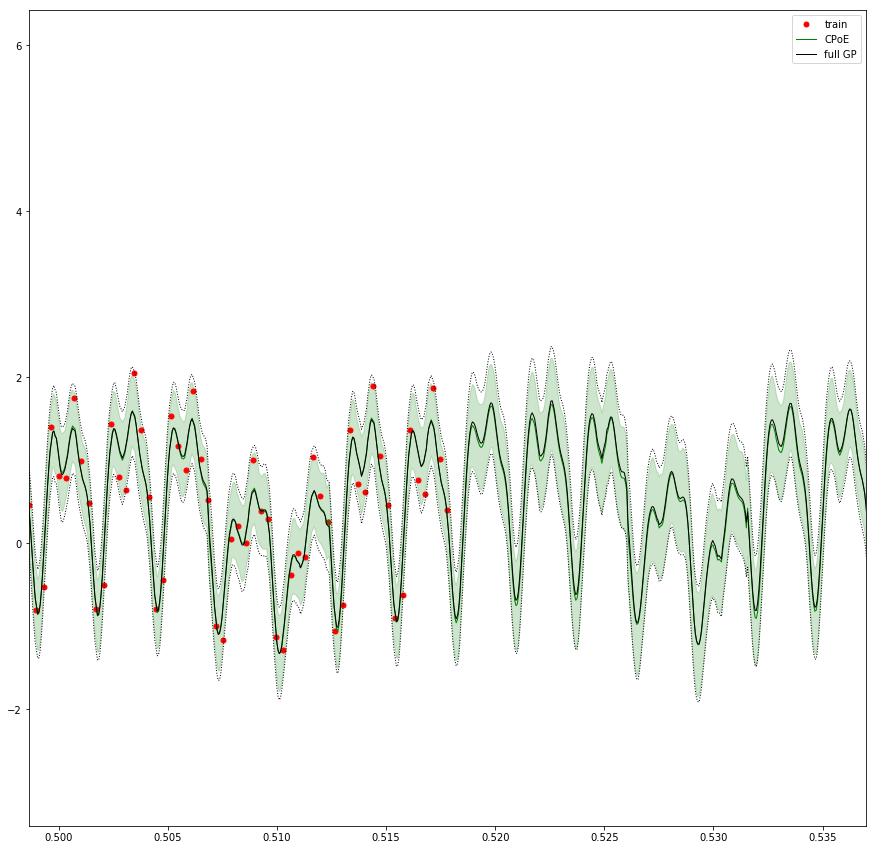

In [152]:
plt.figure(figsize=(15,15))
plt.plot( DD.X_train[:,0] , DD.y_train, 'r.', markersize=10, label='train')

ind_xt = np.argsort(DD.X_test[:,0])
xt = DD.X_test[ind_xt,0]



plt.plot( xt, mod.m[ind_xt], 'g-', markersize=1, linewidth=1.0, label='CPoE')
plt.fill_between(xt, mod.CI[ind_xt,0], mod.CI[ind_xt,1], alpha= 0.2, color='green')


plt.plot( xt, rFullGPo.m[ind_xt], 'k-', markersize=1, linewidth=1.0, label='full GP')

plt.plot( xt, rFullGPo.CI[ind_xt,0], 'k:', markersize=3, linewidth=1.0)
plt.plot( xt, rFullGPo.CI[ind_xt,1], 'k:', markersize=3, linewidth=1.0)


wIN = DD.Xt_IN[ind_xt]
#plt.fill_between(xt[wIN], mod.CI[ind_xt,0][wIN], mod.CI[ind_xt,1][wIN], alpha= 0.1, color='red')

#plt.plot( xt, DD.y_test[ind_xt], 'b-', markersize=1, linewidth=1.0, label='test')
plt.legend()

plt.xlim(weekScale*i1,weekScale*i2)

(-0.05, 1.2)

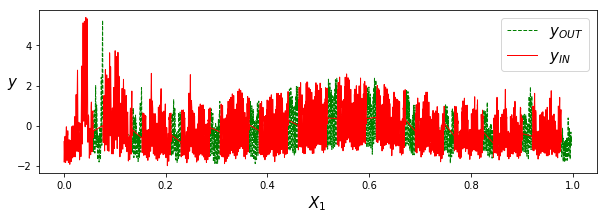

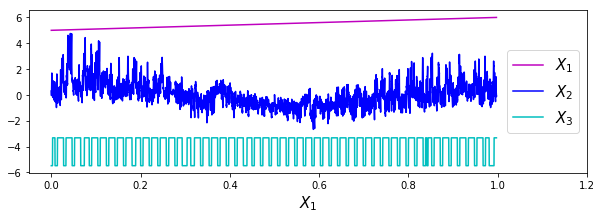

In [153]:
#plt.figure(figsize=(10,3))
#plt.plot( xt , DD.y_test[ind_xt] )

LS = 15
FS = 15


plt.figure(figsize=(10,3))
#plt.plot( xt, mod.m[ind_xt], 'g-', markersize=1, linewidth=1.0, label='CPoE')

wIN = DD.Xt_IN[ind_xt]

plt.plot( xt[wIN==False], DD.y_test[ind_xt][wIN==False], 'g--', markersize=1, linewidth=1.0, label='$y_{OUT}$')
plt.plot( xt[wIN], DD.y_test[ind_xt][wIN], 'r-', markersize=1, linewidth=1.0, label='$y_{IN}$')

plt.ylabel('$y$', rotation='horizontal', size=LS)
plt.xlabel('$X_1$', size=LS)
plt.legend(fontsize=FS)



plt.figure(figsize=(10,3))
plt.plot( xt , DD.X_test[ind_xt,0]+5, 'm-', label='$X_1$' )
plt.plot( xt , DD.X_test[ind_xt,1], 'b', label='$X_2$' )

#plt.figure(figsize=(10,3))
plt.plot( xt , DD.X_test[ind_xt,2]-4, 'c', label='$X_3$' )

plt.xlabel('$X_1$', size=LS)
plt.legend(fontsize=FS, loc=5, ncol=1)
plt.xlim(-0.05,1.2)

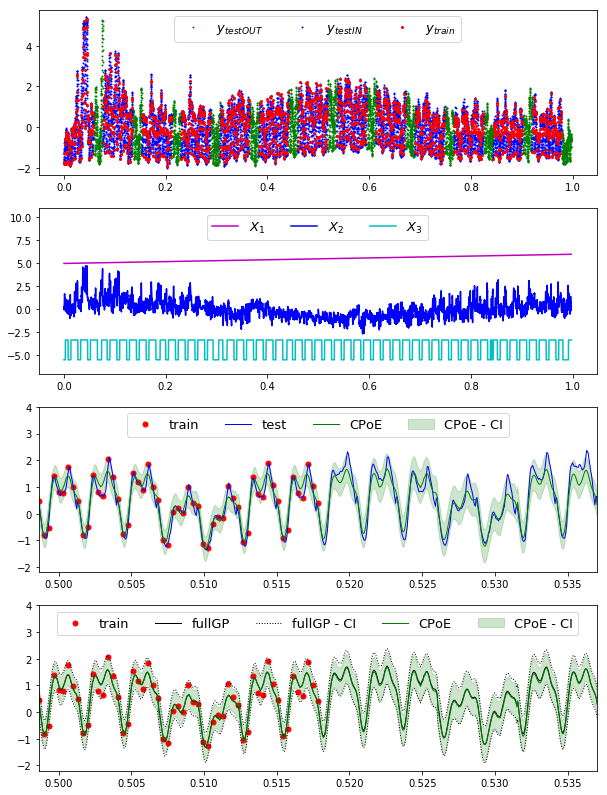

In [157]:
#plt.figure(figsize=(16,3))

f, axs = plt.subplots(4,1, sharex=False, sharey=False, figsize=(10,4*3.5) )

LS = 13
FS = 13
wIN = DD.Xt_IN[ind_xt]
xL0 = -2.2
xL1 = 4

i1 = 26
i2 = 28

ax = axs[0]


ax.plot( xt[wIN==False], DD.y_test[ind_xt][wIN==False], 'g.', markersize=2, linewidth=1.0, label='$y_{testOUT}$')
ax.plot( xt[wIN], DD.y_test[ind_xt][wIN], 'b.', markersize=2, linewidth=1.0, label='$y_{testIN}$')

ax.plot( DD.X_train[:,0] , DD.y_train, 'r.', markersize=4, label='$y_{train}$')

#ax.set_ylabel('$y$', rotation='horizontal', size=LS)
#ax.set_xlabel('$X_1$', size=LS)
ax.legend(fontsize=FS,  ncol=3, loc=9)

#ax.set_xlim(xL0, xL1)


ax = axs[1]
ax.plot( xt , DD.X_test[ind_xt,0]+5, 'm-', label='$X_1$' )
ax.plot( xt , DD.X_test[ind_xt,1], 'b', label='$X_2$' )
ax.plot( xt , DD.X_test[ind_xt,2]-4, 'c', label='$X_3$' )

#ax.set_xlabel('$X_1$', size=LS)
ax.legend(fontsize=FS, loc=9, ncol=3)
#ax.set_xlim(xL0, xL1)
ax.set_ylim(-7,11)
#ax.set_yticks([])



ax = axs[2]


ax.plot( DD.X_train[:,0] , DD.y_train, 'r.', markersize=10, label='train')
ax.plot( xt, DD.y_test[ind_xt], 'b-', markersize=1, linewidth=1.0, label='test')


ax.plot( xt, mod.m[ind_xt], 'g-', markersize=1, linewidth=1.0, label='CPoE')

ax.fill_between(xt, mod.CI[ind_xt,0], mod.CI[ind_xt,1], alpha= 0.2, color='green', label='CPoE - CI')
#ax.fill_between(xt[wIN], mod.CI[ind_xt,0][wIN], mod.CI[ind_xt,1][wIN], alpha= 0.1, color='red')
ax.set_xlim(weekScale*i1,weekScale*i2)

ax.legend(fontsize=FS, loc=9, ncol=4)
ax.set_ylim(xL0, xL1)



ax = axs[3]
ax.plot( DD.X_train[:,0] , DD.y_train, 'r.', markersize=10, label='train')

ax.plot( xt, rFullGPo.m[ind_xt], 'k-', markersize=1, linewidth=1.0, label='fullGP')

ax.plot( xt, rFullGPo.CI[ind_xt,0], 'k:', markersize=3, linewidth=1.0, label='fullGP - CI')
ax.plot( xt, rFullGPo.CI[ind_xt,1], 'k:', markersize=3, linewidth=1.0)

ax.plot( xt, mod.m[ind_xt], 'g-', markersize=1, linewidth=1.0, label='CPoE')
ax.fill_between(xt, mod.CI[ind_xt,0], mod.CI[ind_xt,1], alpha= 0.2, color='green', label='CPoE - CI')

ax.set_xlim(weekScale*i1,weekScale*i2)
ax.legend(fontsize=FS, loc=9, ncol=5)

ax.set_ylim(xL0, xL1);


plt.savefig(''+'timeSeries'+'.pdf', bbox_inches = 'tight', pad_inches = 0);

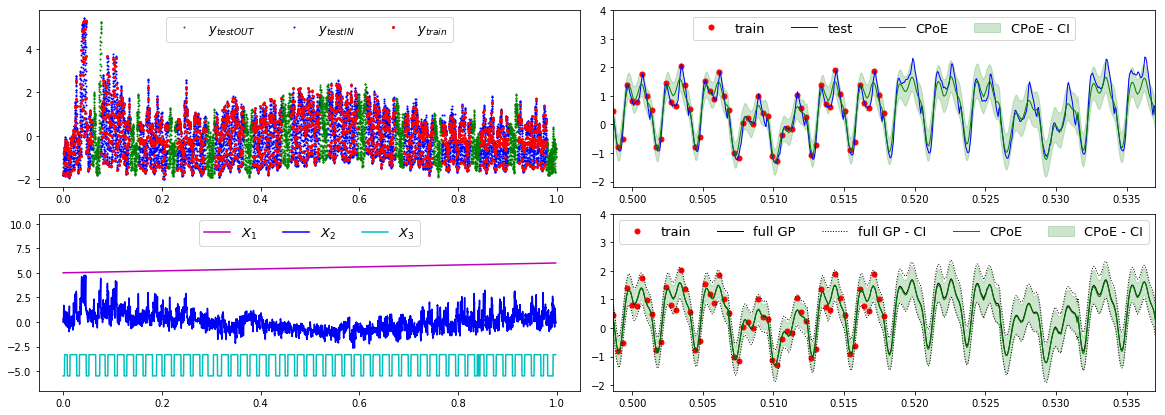

In [172]:
#plt.figure(figsize=(16,3))

f, axs = plt.subplots(2,2, sharex=False, sharey=False, figsize=(20,2*3.5) )
f.subplots_adjust(hspace=0.15, wspace=0.06)

LS = 13
FS = 13
wIN = DD.Xt_IN[ind_xt]
xL0 = -2.2
xL1 = 4

i1 = 26
i2 = 28

ax = axs[0,0]


ax.plot( xt[wIN==False], DD.y_test[ind_xt][wIN==False], 'g.', markersize=2, linewidth=1.0, label='$y_{testOUT}$')
ax.plot( xt[wIN], DD.y_test[ind_xt][wIN], 'b.', markersize=2, linewidth=1.0, label='$y_{testIN}$')

ax.plot( DD.X_train[:,0] , DD.y_train, 'r.', markersize=4, label='$y_{train}$')

#ax.set_ylabel('$y$', rotation='horizontal', size=LS)
#ax.set_xlabel('$X_1$', size=LS)
ax.legend(fontsize=FS,  ncol=3, loc=9)

#ax.set_xlim(xL0, xL1)


ax = axs[1,0]
ax.plot( xt , DD.X_test[ind_xt,0]+5, 'm-', label='$X_1$' )
ax.plot( xt , DD.X_test[ind_xt,1], 'b', label='$X_2$' )
ax.plot( xt , DD.X_test[ind_xt,2]-4, 'c', label='$X_3$' )

#ax.set_xlabel('$X_1$', size=LS)
ax.legend(fontsize=FS, loc=9, ncol=3)
#ax.set_xlim(xL0, xL1)
ax.set_ylim(-7,11)
#ax.set_yticks([])



ax = axs[0,1]


ax.plot( DD.X_train[:,0] , DD.y_train, 'r.', markersize=10, label='train')
ax.plot( xt, DD.y_test[ind_xt], 'b-', markersize=1, linewidth=1.0, label='test')


ax.plot( xt, mod.m[ind_xt], 'g-', markersize=1, linewidth=1.0, label='CPoE')

ax.fill_between(xt, mod.CI[ind_xt,0], mod.CI[ind_xt,1], alpha= 0.2, color='green', label='CPoE - CI')
#ax.fill_between(xt[wIN], mod.CI[ind_xt,0][wIN], mod.CI[ind_xt,1][wIN], alpha= 0.1, color='red')
ax.set_xlim(weekScale*i1,weekScale*i2)

ax.legend(fontsize=FS, loc=9, ncol=4)
ax.set_ylim(xL0, xL1)



ax = axs[1,1]
ax.plot( DD.X_train[:,0] , DD.y_train, 'r.', markersize=10, label='train')

ax.plot( xt, rFullGPo.m[ind_xt], 'k-', markersize=1, linewidth=1.0, label='full GP')

ax.plot( xt, rFullGPo.CI[ind_xt,0], 'k:', markersize=3, linewidth=1.0, label='full GP - CI')
ax.plot( xt, rFullGPo.CI[ind_xt,1], 'k:', markersize=3, linewidth=1.0)

ax.plot( xt, mod.m[ind_xt], 'g-', markersize=1, linewidth=1.0, label='CPoE')
ax.fill_between(xt, mod.CI[ind_xt,0], mod.CI[ind_xt,1], alpha= 0.2, color='green', label='CPoE - CI')

ax.set_xlim(weekScale*i1,weekScale*i2)
ax.legend(fontsize=FS, loc=9, ncol=5)

ax.set_ylim(xL0, xL1);


plt.savefig(''+'timeSeries2'+'.pdf', bbox_inches = 'tight', pad_inches = 0);

In [560]:
Bk = mod.obj.B
Bk

168

In [561]:
mod.obj.predecessors_and_k

[array([0]),
 array([0, 1]),
 array([0, 1, 2]),
 array([0, 1, 2, 3]),
 array([0, 2, 3, 4]),
 array([2, 3, 4, 5]),
 array([3, 4, 5, 6]),
 array([4, 5, 6, 7]),
 array([4, 6, 7, 8]),
 array([4, 5, 8, 9]),
 array([ 3,  5,  9, 10]),
 array([ 3,  9, 10, 11]),
 array([ 3, 10, 11, 12])]

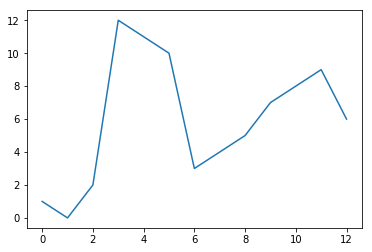

In [793]:
plt.plot( mod.obj.ppi0 )

In [794]:
mod.obj.ppi0

array([ 1,  0,  2, 12, 11, 10,  3,  4,  5,  7,  8,  9,  6], dtype=int32)

In [570]:
S = mod.obj.FQF.toarray()

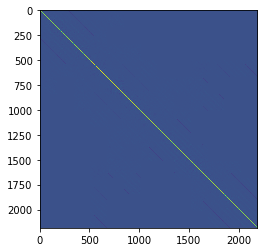

In [571]:
plt.imshow( S )

In [555]:
ni, nj = mod.obj.FQF.nonzero()

In [556]:
KK = mod.obj.kern.K(DD.X_train)

In [557]:
iS = np.linalg.inv(S)

In [558]:
iK = np.linalg.inv(KK)

In [543]:
KK

array([[1.2370504 , 1.015396  , 0.69572512, ..., 0.02767076, 0.10290653,
        0.3369369 ],
       [1.015396  , 1.2370504 , 0.96716189, ..., 0.01255285, 0.02767076,
        0.10290653],
       [0.69572512, 0.96716189, 1.2370504 , ..., 0.01941817, 0.01255285,
        0.02767076],
       ...,
       [0.02767076, 0.01255285, 0.01941817, ..., 1.2370504 , 1.01461289,
        0.76698608],
       [0.10290653, 0.02767076, 0.01255285, ..., 1.01461289, 1.2370504 ,
        1.01744671],
       [0.3369369 , 0.10290653, 0.02767076, ..., 0.76698608, 1.01744671,
        1.2370504 ]])

In [544]:
iS

array([[ 1.2380504 ,  1.015396  ,  0.69572512, ..., -0.07255415,
         0.00248237,  0.23643765],
       [ 1.015396  ,  1.2380504 ,  0.96716189, ..., -0.08748365,
        -0.07265724,  0.00254445],
       [ 0.69572512,  0.96716189,  1.2380504 , ..., -0.08058934,
        -0.08773587, -0.07271804],
       ...,
       [-0.07255415, -0.08748365, -0.08058934, ...,  1.23349038,
         1.01011087,  0.7625007 ],
       [ 0.00248237, -0.07265724, -0.08773587, ...,  1.01011087,
         1.23352516,  1.01295332],
       [ 0.23643765,  0.00254445, -0.07271804, ...,  0.7625007 ,
         1.01295332,  1.23351031]])

In [539]:
KK - iS

array([[-0.001     , -0.        , -0.        , ...,  0.10022491,
         0.10042417,  0.10049925],
       [-0.        , -0.001     , -0.        , ...,  0.10003649,
         0.100328  ,  0.10036208],
       [-0.        , -0.        , -0.001     , ...,  0.1000075 ,
         0.10028871,  0.1003888 ],
       ...,
       [ 0.10022491,  0.10003649,  0.1000075 , ...,  0.00356001,
         0.00450202,  0.00448539],
       [ 0.10042417,  0.100328  ,  0.10028871, ...,  0.00450202,
         0.00352523,  0.0044934 ],
       [ 0.10049925,  0.10036208,  0.1003888 , ...,  0.00448539,
         0.0044934 ,  0.00354009]])

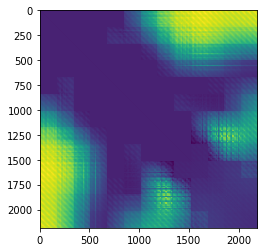

In [683]:
plt.imshow( KK - iS )

In [540]:
(KK - iS)[ni, nj]

array([-0.001     , -0.        , -0.        , ...,  0.00448539,
        0.0044934 ,  0.00354009])

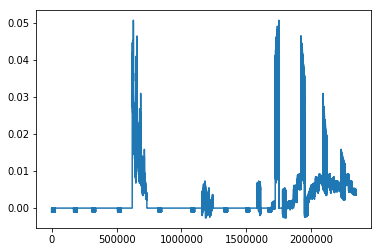

In [545]:
plt.plot((KK - iS)[ni, nj])

In [541]:
np.max( np.abs( (KK - iS)[ni, nj] ) )

0.050667527301233646

In [542]:
np.max( np.abs( iS ) )

1.2380503956389255

In [783]:
j = 12
inds_j = np.repeat( mod.obj.predecessors_and_k[j]*Bk , Bk) + np.tile ( np.arange(Bk), 4 )
#inds_j = np.repeat( mod.obj.predecessors_and_k[j][1:]*Bk , Bk) + np.tile ( np.arange(Bk), 3 )
#inds_j = np.repeat( mod.obj.predecessors[j]*Bk , Bk) + np.tile ( np.arange(Bk), 3 )

In [784]:
GF = (KK - iS)[inds_j[np.newaxis,:], inds_j[:,np.newaxis]]
GF

array([[-0.001     ,  0.        ,  0.        , ...,  0.00856001,
         0.00849588,  0.00844788],
       [ 0.        , -0.001     ,  0.        , ...,  0.00839575,
         0.0083567 ,  0.00830537],
       [ 0.        ,  0.        , -0.001     , ...,  0.00858082,
         0.00852384,  0.00847758],
       ...,
       [ 0.00856001,  0.00839575,  0.00858082, ...,  0.00356001,
         0.00450202,  0.00448539],
       [ 0.00849588,  0.0083567 ,  0.00852384, ...,  0.00450202,
         0.00352523,  0.0044934 ],
       [ 0.00844788,  0.00830537,  0.00847758, ...,  0.00448539,
         0.0044934 ,  0.00354009]])

In [785]:
np.round(GF,3)

array([[-0.001,  0.   ,  0.   , ...,  0.009,  0.008,  0.008],
       [ 0.   , -0.001,  0.   , ...,  0.008,  0.008,  0.008],
       [ 0.   ,  0.   , -0.001, ...,  0.009,  0.009,  0.008],
       ...,
       [ 0.009,  0.008,  0.009, ...,  0.004,  0.005,  0.004],
       [ 0.008,  0.008,  0.009, ...,  0.005,  0.004,  0.004],
       [ 0.008,  0.008,  0.008, ...,  0.004,  0.004,  0.004]])

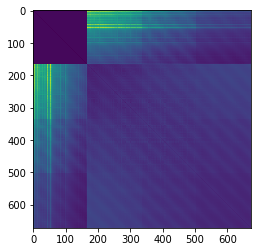

In [786]:
plt.imshow(GF)

In [792]:
np.sum( mod.obj.factor.P() == np.arange(2184) )

2184

In [763]:
PHIS = np.zeros_like(iS)
PHIS2 = np.zeros_like(iS)

for j in range(mod.obj.K):
    inds_j = np.repeat( mod.obj.predecessors_and_k[j]*Bk , Bk) + np.tile ( np.arange(Bk), len(mod.obj.predecessors_and_k[j]) )
    PHIS[inds_j[np.newaxis,:], inds_j[:,np.newaxis]] = 1
    
    inds_k = np.repeat( j*Bk , Bk) + np.arange(Bk)
    PHIS2[inds_k[np.newaxis,:], inds_j[:,np.newaxis]] = 1
    PHIS2[inds_j[np.newaxis,:], inds_k[:,np.newaxis]] = 1
    

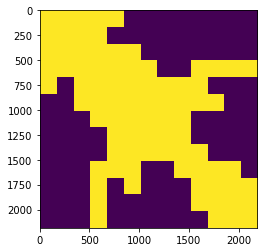

In [765]:
plt.imshow(PHIS)

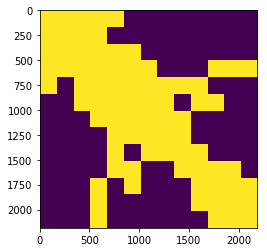

In [766]:
plt.imshow(PHIS2)

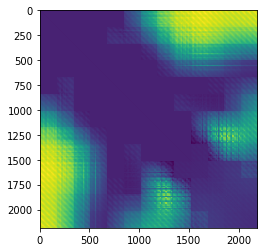

In [767]:
plt.imshow( KK - iS )

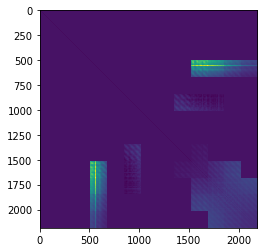

In [781]:
plt.imshow( (KK - iS)*PHIS )

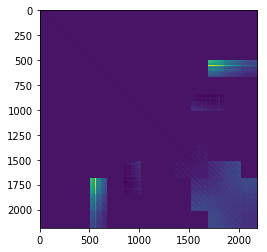

In [782]:
plt.imshow( (KK - iS)*PHIS2 )

In [777]:
j = 9
inds_j = np.repeat( mod.obj.predecessors_and_k[j]*Bk , Bk) + np.tile ( np.arange(Bk), len(mod.obj.predecessors_and_k[j]) )
inds_k = np.repeat( j*Bk , Bk) + np.arange(Bk)
PHIS[inds_k[np.newaxis,:], inds_j[:,np.newaxis]] = 1

In [778]:
GF = (KK - iS)[inds_k[np.newaxis,:], inds_j[:,np.newaxis]]
GF

array([[-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.        , -0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.00141903,  0.00139174,  0.00135739, ...,  0.00092004,
         0.00192015,  0.0019053 ],
       [ 0.00142624,  0.0014093 ,  0.00138024, ...,  0.00192015,
         0.00094811,  0.00190433],
       [ 0.00141993,  0.00140123,  0.00138698, ...,  0.0019053 ,
         0.00190433,  0.00086605]])

In [779]:
np.round(GF,3)

array([[-0.   , -0.   , -0.   , ..., -0.   , -0.   , -0.   ],
       [ 0.   , -0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.001,  0.001,  0.001, ...,  0.001,  0.002,  0.002],
       [ 0.001,  0.001,  0.001, ...,  0.002,  0.001,  0.002],
       [ 0.001,  0.001,  0.001, ...,  0.002,  0.002,  0.001]])

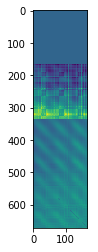

In [780]:
plt.imshow(GF)

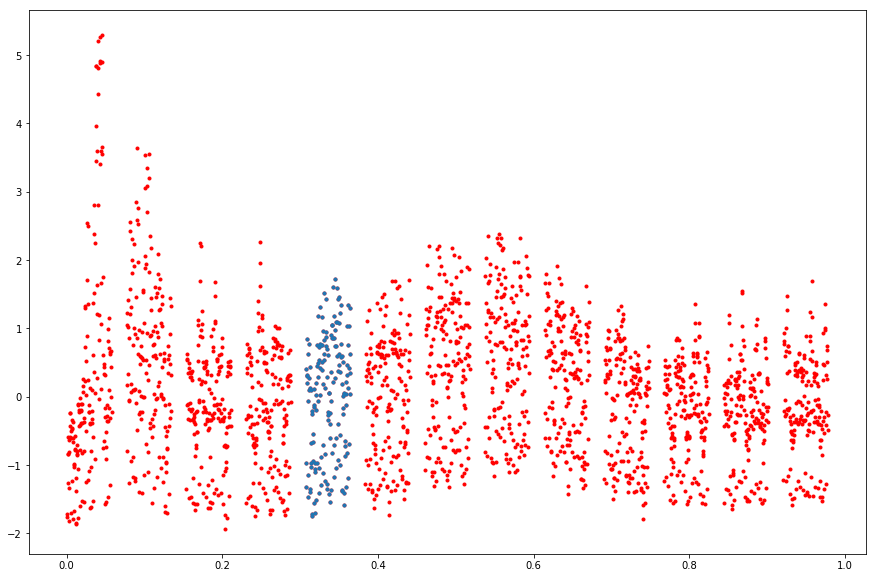

In [123]:
plt.figure(figsize=(15,10))
plt.plot( DD.X_train[:,0] , DD.y_train, 'r.', label='train')

#for k in range(mod.obj.PART.K):
    
k = 4
plt.plot(mod.obj.PART.X_trains_k[k][:,0] , mod.obj.PART.y_trains_k[k], '.', label='train')

